In [1]:
# verify GPU availability
import tensorflow as tf

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [2]:
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm() 

  Created wheel for gputil: filename=GPUtil-1.4.0-cp36-none-any.whl size=7410 sha256=196d60aa994b6da9a66a8abc0081d99228d6a678c352a92a22abac383af7d3f7
  Stored in directory: /root/.cache/pip/wheels/3d/77/07/80562de4bb0786e5ea186911a2c831fdd0018bda69beab71fd
Successfully built gputil
Gen RAM Free: 26.1 GB  | Proc size: 548.2 MB
GPU RAM Free: 16015MB | Used: 265MB | Util   2% | Total 16280MB


In [3]:
!ps ax | grep python

     18 ?        Sl     0:01 /usr/bin/python2 /usr/local/bin/jupyter-notebook --ip="172.28.0.2" --port=9000 --FileContentsManager.root_dir="/" --MappingKernelManager.root_dir="/content"
    148 ?        Ssl    0:03 /usr/bin/python3 -m ipykernel_launcher -f /root/.local/share/jupyter/runtime/kernel-fd56ee1f-9c45-41ce-8ed3-5d3b24f7f339.json
    254 ?        S      0:00 /bin/bash -c ps ax | grep python


In [0]:
#!kill -9 366

In [0]:
# d=[]
# while(1):
#   d.append('1')

In [6]:
!pip install pytorch-pretrained-bert pytorch-nlp

     |████████████████████████████████| 133kB 2.8MB/s 
     |████████████████████████████████| 92kB 10.7MB/s 
     |████████████████████████████████| 645kB 51.5MB/s 


In [7]:
# BERT imports
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from pytorch_pretrained_bert import BertTokenizer, BertConfig
from pytorch_pretrained_bert import BertAdam, BertForSequenceClassification
from tqdm import tqdm, trange
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
% matplotlib inline

# specify GPU device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

Using TensorFlow backend.


'Tesla P100-PCIE-16GB'

In [0]:
torch.cuda.empty_cache()

In [9]:
files = [f for f in glob.glob("*.csv")]
df_raw = pd.DataFrame()
counter = 0
for file in files:
  counter += 1
  df = pd.read_csv(file, delimiter=',', header=None, names=['label_SALLY', 'text', 'line', 'start_pos', 'end_pos', 'file'])
  #df['text'] = df['text'].apply(str)
  #df.head()
  df_raw = pd.concat([df_raw , df], ignore_index=True)

#df = df_raw.dropna()
df.head()
print("total files : ", counter)
sentences = df.text.values
#print(sentences)

total files :  16


In [0]:
sentences = ["[CLS] " + sentence + " [SEP]" for sentence in sentences]
labels = df.label_SALLY.values
#print(labels)
df.label_SALLY = df.label_SALLY.apply(lambda v: 1 if v == "U" else 0)
labels = df.label_SALLY.values

#print(labels)


In [11]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

tokenized_texts = [tokenizer.tokenize(sentence) for sentence in sentences]
#print("Tokenize the first sentence :")
#print(tokenized_texts)
max = -1
for items in sentences:
  if len(items) > max:
    print(max)
    max = len(items)

#print(max)

100%|██████████| 231508/231508 [00:00<00:00, 5736180.69B/s]


-1
16
55
76
332
599
636
919
983


In [0]:
# Set the maximum sequence length. The longest sequence in our training set is 47, but we'll leave room on the end anyway. 
# In the original paper, the authors used a length of 512.
MAX_LEN = 128

In [0]:
# Use the BERT tokenizer to convert the tokens to their index numbers in the BERT vocabulary
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]

In [0]:
# Pad our input tokens
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

In [0]:
# Create attention masks
attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask)

In [0]:
# Use train_test_split to split our data into train and validation sets for training

train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, 
                                                            random_state=2018, test_size=0.1)
train_masks, validation_masks, _, _ = train_test_split(attention_masks, input_ids,
                                             random_state=2018, test_size=0.1)

In [0]:
# Convert all of our data into torch tensors, the required datatype for our model

train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)
train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

In [0]:
# Select a batch size for training. For fine-tuning BERT on a specific task, the authors recommend a batch size of 16 or 32
batch_size = 32

# Create an iterator of our data with torch DataLoader. This helps save on memory during training because, unlike a for loop, 
# with an iterator the entire dataset does not need to be loaded into memory

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)


In [0]:
# Load BertForSequenceClassification, the pretrained BERT model with a single linear classification layer on top. 

model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)
model.cuda()

In [0]:
# !nvidia-smi

In [0]:

param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]



In [22]:
# This variable contains all of the hyperparemeter information our training loop needs
optimizer = BertAdam(optimizer_grouped_parameters,
                     lr=2e-5,
                     warmup=.1)

t_total value of -1 results in schedule not being applied


In [0]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [24]:
t = [] 

# Store our loss and accuracy for plotting
train_loss_set = []

# Number of training epochs (authors recommend between 2 and 4)
epochs = 4

# trange is a tqdm wrapper around the normal python range
for _ in trange(epochs, desc="Epoch"):
  
  
  # Training
  
  # Set our model to training mode (as opposed to evaluation mode)
  model.train()
  
  # Tracking variables
  tr_loss = 0
  nb_tr_examples, nb_tr_steps = 0, 0
  
  # Train the data for one epoch
  for step, batch in enumerate(train_dataloader):
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Clear out the gradients (by default they accumulate)
    optimizer.zero_grad()
    # Forward pass
    loss = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
    train_loss_set.append(loss.item())    
    # Backward pass
    loss.backward()
    # Update parameters and take a step using the computed gradient
    optimizer.step()
    
    
    # Update tracking variables
    tr_loss += loss.item()
    nb_tr_examples += b_input_ids.size(0)
    nb_tr_steps += 1

  print("Train loss: {}".format(tr_loss/nb_tr_steps))
    
    
  # Validation

  # Put model in evaluation mode to evaluate loss on the validation set
  model.eval()

  # Tracking variables 
  eval_loss, eval_accuracy = 0, 0
  nb_eval_steps, nb_eval_examples = 0, 0

  # Evaluate data for one epoch
  for batch in validation_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Telling the model not to compute or store gradients, saving memory and speeding up validation
    with torch.no_grad():
      # Forward pass, calculate logit predictions
      logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
    
    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    tmp_eval_accuracy = flat_accuracy(logits, label_ids)
    
    eval_accuracy += tmp_eval_accuracy
    nb_eval_steps += 1

  print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))

Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Train loss: 0.38444502438817707


Epoch:  25%|██▌       | 1/4 [00:07<00:21,  7.32s/it]

Validation Accuracy: 0.953125
Train loss: 0.3100279857005392


Epoch:  50%|█████     | 2/4 [00:14<00:14,  7.28s/it]

Validation Accuracy: 0.953125
Train loss: 0.29752895874636515


Epoch:  75%|███████▌  | 3/4 [00:21<00:07,  7.26s/it]

Validation Accuracy: 0.953125
Train loss: 0.2597881518304348


Epoch: 100%|██████████| 4/4 [00:28<00:00,  7.24s/it]

Validation Accuracy: 0.953125


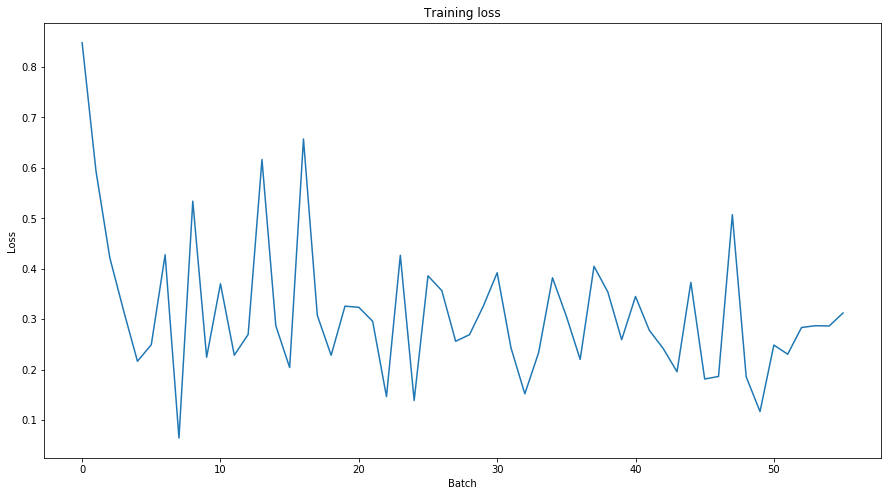

In [25]:
plt.figure(figsize=(15,8))
plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(train_loss_set)
plt.show()

In [0]:
df = pd.read_csv("/content/test/ML11244A041.csv", delimiter=',', header=None, names=['label_SALLY', 'text', 'line', 'start_pos', 'end_pos', 'file'])

# Create sentence and label lists
sentences = df.text.values
print(sentences)

# We need to add special tokens at the beginning and end of each sentence for BERT to work properly
sentences = ["[CLS] " + sentence + " [SEP]" for sentence in sentences]
df.label_SALLY = df.label_SALLY.apply(lambda v: 1 if v == "U" else 0)
labels = df.label_SALLY.values

tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]


MAX_LEN = 128

# Use the BERT tokenizer to convert the tokens to their index numbers in the BERT vocabulary
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
# Pad our input tokens
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")
# Create attention masks
attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask) 

prediction_inputs = torch.tensor(input_ids)
prediction_masks = torch.tensor(attention_masks)
prediction_labels = torch.tensor(labels)
  
batch_size = 32  


prediction_data = TensorDataset(prediction_inputs, prediction_masks, prediction_labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

In [48]:
# Prediction on test set

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  # Telling the model not to compute or store gradients, saving memory and speeding up prediction
  with torch.no_grad():
    # Forward pass, calculate logit predictions
    logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)
print(predictions[0])
print(true_labels[0])

[[-1.8686612   1.7278905 ]
 [-2.1329405   1.966919  ]
 [-2.4372587   2.1927614 ]
 [-2.0853002   1.9290377 ]
 [-2.2969065   2.0822785 ]
 [-2.399864    2.1761968 ]
 [-0.56592935  0.54274744]
 [-0.60818374  0.5752276 ]
 [-0.43459618  0.44509625]
 [-0.91005147  0.8249724 ]
 [-0.5997151   0.56724775]
 [-0.5102501   0.49760216]
 [-0.7936696   0.71872973]
 [-0.56712514  0.5388259 ]
 [-0.4050845   0.42347765]
 [-0.4122793   0.4287644 ]
 [-2.2335858   2.0717897 ]
 [-2.267357    2.0737567 ]
 [-0.591695    0.56124413]
 [-1.7347547   1.5579046 ]
 [-2.2922719   2.1450489 ]
 [-2.3113616   2.177635  ]
 [-2.4329636   2.190709  ]
 [-2.3289096   2.091159  ]
 [-2.147621    2.05878   ]
 [-1.980754    1.8193765 ]
 [-2.4187324   2.1349523 ]
 [-2.4264028   2.149929  ]
 [-2.4195685   2.139059  ]
 [-1.980754    1.8193765 ]
 [-2.4153738   2.1764143 ]
 [-2.200772    2.10088   ]]
[0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


In [45]:
total_correct = 0;
for i in range(len(true_labels)):
  if (true_labels[i] == np.argmax(predictions[i], axis=1).flatten()):
    total_correct += 1

print("Total Correct = ", total_correct)
print("Accuracy = ", (total_correct/len(true_labels))*100,'%')

ValueError: ignored

In [40]:
# Import and evaluate each test batch using Matthew's correlation coefficient
from sklearn.metrics import matthews_corrcoef
matthews_set = []

for i in range(len(true_labels)):
  matthews = matthews_corrcoef(true_labels[i],
                 np.argmax(predictions[i], axis=1).flatten())
  matthews_set.append(matthews)

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


In [41]:
matthews_set

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

In [0]:
# Flatten the predictions and true values for aggregate Matthew's evaluation on the whole dataset
flat_predictions = [item for sublist in predictions for item in sublist]
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()
flat_true_labels = [item for sublist in true_labels for item in sublist]


In [38]:
matthews_corrcoef(flat_true_labels, flat_predictions)

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


0.0